In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
def get_test_track(s):
    i,moves,des = s.split(' ')
    moves=moves.split(';')[:-1]
    moves=[move.split(',') for move in moves]
    moves=[[int(ll) for ll in l] for l in moves]
    des=[float(p) for p in des.split(',')]
#     flag=int(flag)
#     print(i,moves[0],'->',des,flag)
    m = np.matrix(moves)
    m = m[np.lexsort(m.T)][0]
#     print(m)
    return (i,(m[0,0],m[0,1]), m, des)
    

In [5]:

def get_track(s):
    i,moves,des,flag = s.split(' ')
    moves=moves.split(';')[:-1]
    moves=[move.split(',') for move in moves]
    moves=[[int(ll) for ll in l] for l in moves]
    des=[float(p) for p in des.split(',')]
    flag=int(flag)
#     print(i,moves[0],'->',des,flag)
    m = np.matrix(moves)
    m = m[np.lexsort(m.T)][0]
#     print(m)
    return (i,(m[0,0],m[0,1]), m, des, flag)
def to_percent(mat):
    return np.nan_to_num(mat/mat.sum(axis=1).reshape(-1,1))
def plot(data, rows=3, cols=3):
    for i,s in enumerate(data):
        if i >= rows*cols:
            break
        start, track, des, flag = get_track(s)
        canvas = plts[i//cols][i%cols]
        canvas.plot(*start, '.b')
        canvas.plot(track[:,0],track[:,1],'-g')
        canvas.plot(*des,'.r')

In [6]:

#按首列分布聚合
def get_distr(mat, part=4, min=None, max=None, percent=True):
    assert part!=0
    assert mat.shape[1] >= 2
    min = mat[:,0].min() if min is None else min
    max = mat[:,0].max() if max is None else max
    parts = []
    space = (max-min)/part
    for i in range(part):
        RangeBool = np.all([mat[:,0]>=space*i+min,mat[:,0]<space*(i+1)+min],axis=0)
        parts.append(RangeBool.flat)
    distributions = np.array([mat[np.ix_(p, [0,1])].sum(axis=0).flat[1] for p in parts])
    distributions = to_percent(distributions.reshape(1, -1)) if percent else distributions
    return distributions
    
def theta_distr(theta, part=4):
    return get_distr(theta, part, min=0, max=math.pi)

In [7]:
human = []
machine = []
test = []
with open('dsjtzs_txfz_training.txt') as f:
    people = list(filter(lambda l:l.strip().endswith('1'),f.readlines()))
    f.seek(0)
    machine = list(filter(lambda l:l.strip().endswith('0'),f.readlines()))
with open('dsjtzs_txfz_test1.txt') as f:
    test = f.readlines()

In [9]:
def find_stab(track, stride=100, height=30, max_t=50):
    pace = stride / 2
    stabs = []
    trackT = track.copy()
    trackT[1:,2] = trackT[1:,0]>=trackT[:-1,0]
    trackT[0,2] = 1
#     print(track)
    for i in range(1, track.shape[0]):
        trend = track[i,0] >= track[i-1,0]
        Range = np.all([track[:,0]>=track[i,0]-pace,
                        track[:,0]<=track[i,0]+pace,
                        trackT[:,2]==trend ,
                        np.abs(track[:,2] - track[i,2]) < max_t,
                       ],axis=0)
        r = track[np.ix_(Range.flat, [0,1])]
        s = np.abs(track[i,1] - (r[0,1]+r[-1,1])/2)
        if s > height:
            stabs.append(np.hstack([track[i,0:2], np.matrix([s])]))
#         print(r[0,1], r[-1,1], (r[0,1]+r[-1,1])/2, track[i,1] - (r[0,1]+r[-1,1])/2)
    if len(stabs) > 0:
        return np.vstack([*stabs])
    else:
        return np.zeros((1,3))#固有
    
def find_stab_2(track,height=20):
    stabs = []
    track[1:,2] = track[1:,1]>=track[:-1,1]
    track[0,2] = track[1,2]
    track[:-1,2] = np.abs(track[1:,2] - track[:-1,2])
    track[-1,2] = 0
#     print(track)
    stabs = track[np.ix_((track[:,2]==1).flat, [0,1])]
    if stabs.shape[0] == 0:
        return None
    condx = np.all([np.abs(stabs[1:,1]-stabs[:-1,1])>=height,], axis=0)
    return np.vstack([stabs[0],stabs[1:][np.ix_(condx.flat, [0,1])]])
    
index, start, track, des, flag = get_track(machine[392])
find_stab_2(track)

matrix([[ 388, 2620],
        [ 465, 2477],
        [ 647, 2737],
        [ 759, 2503]])

In [10]:
import random
rows = 100
# random.shuffle(people)
# random.shuffle(machine)
for i,s in enumerate(machine[300:]):
    if i >= rows:
        break
    index, start, track, des, flag = get_track(s)
    track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
    delta = track[1:] - track[:-1]
    delta[:,2]+=1#固定偏差用来消除0
    
    angular = np.arccos(delta[:,0]/np.sqrt(np.square(delta[:,0])+np.square(delta[:,1])))
    angular = np.nan_to_num(angular)
    angularDeltaTime = np.hstack((angular, delta[:,2]))#x1角度,x2为时间差
    timeAngular = np.hstack((track[1:,2],angular))#x1为时间，x2为角度
    
    angularVelocity = (angular[1:] - angular[:-1])/delta[1:,2]#角速度
    angularVelocityDeltaTime = np.hstack((np.nan_to_num(angularVelocity), delta[1:,2]))#x1角度,x2为时间差
    timeAngularVelocity = np.hstack((track[2:,2],np.nan_to_num(angularVelocity)))#x1为时间，x2为角度
    
    speed = np.sqrt(np.square(delta[:,0])+np.square(delta[:,1]))/delta[:,2]
    timeSpeed = np.hstack((track[1:,2],np.nan_to_num(speed)))#x1为时间，x2为速度
    speedDeltaTime = np.hstack((np.nan_to_num(speed), delta[:,2]))#x1为速度，x2为时间差
    
    acceleration = (speed[1:,0] - speed[:-1,0])/delta[1:,2]#加速度
    accelerationDeltaTime = np.hstack((np.nan_to_num(acceleration), delta[1:,2]))
    timeAcceleration = np.hstack((track[2:,2], np.nan_to_num(acceleration)))
    
    trackGrad = (track[1:,1] - track[:-1,1])/(track[1:,0] - track[:-1,0])
#     trackHessen = (trackGrad[1:,1] - trackGrad[:-1,1])/(trackGrad[1:,0] - trackGrad[:-1,0])
#     print('speed-max:%f'%speed[:,0].max()
#           ,"mean:%f"%speed[:,0].mean()
#           ,"std:%f"%speed[:,0].std()
#           ,"%%25time speed:%f"%(get_distr(timeSpeed,part=4)[0][0])
#           ,"%%25speed time:%f"%(get_distr(speedDeltaTime,part=4)[0][0])
#          )    

#     print('acceleration-max:%f'%acceleration[:,0].max()
#           ,"mean:%f"%acceleration[:,0].mean()
#           ,"std:%f"%acceleration[:,0].std()
#           ,"%%25time acceleration:%f"%(get_distr(timeAcceleration,part=4)[0][0])
#           ,"%%25acceleration time:%f"%(get_distr(accelerationDeltaTime,part=4)[0][0])
#          )

#     print('angular-max:%f'%angular[:,0].max()
#       ,"mean:%f"%angular[:,0].mean()
#       ,"std:%f"%angular[:,0].std()
#       ,"%%25time angular:%f"%(get_distr(timeAngular,part=4)[0][0])
#       ,"longest angular time:%f"%(get_distr(angularDeltaTime,part=16)[0].max())
#      )
    
#     print('angularVelocity-max:%f'%angularVelocity[:,0].max()
#       ,"mean:%f"%np.abs(angularVelocity[:,0]).mean()
#       ,"std:%f"%angularVelocity[:,0].std()
#       ,"%%25 time angularVelocity:%f"%(get_distr(np.abs(timeAngularVelocity),part=4)[0][0])
#       ,"%%25 angularVelocity time:%f"%(get_distr(np.abs(angularVelocityDeltaTime),part=8)[0][0])
#      )
    
#     print('track-range-x:%f -y:%f'%((track[:,0].max() - track[:,0].min()), (track[:,1].max() - track[:,1].min()))
#       ,"mean-x:%f -y:%f"%((track[:,0].mean()), (track[:,1].mean()))
#       ,"std-x:%f -y%f"%((track[:,0].std()), (track[:,1].std()))
#       ,"hessen:%f"%(1)
# #     ,"%%25 time track:%f"%(get_distr(np.abs(track[:,0:]),part=4)[0][0])
# #     ,"%%25 track time:%f"%(get_distr(np.abs(angularVelocityDeltaTime),part=8)[0][0])
#      )

#     print(trackHessen)
    stabs = find_stab_2(track,height=25)
    if stabs is None:
        print(0, 0, 0)
    elif stabs.shape[0] == 1:
        print(1, 0, 0)
    else:
        print(stabs.shape[0], np.abs(stabs[1:,1]-stabs[:-1,1]).mean(), np.abs(stabs[1:,1]-stabs[:-1,1]).max())
        if stabs.shape[0] >= 3:
            print(((stabs[1:-1,1] - (stabs[2:,1]+stabs[:-2,1])/2)/(stabs[2:,0]-stabs[:-2,0])).max())
    print('-'*6)
#     print(get_distr(speed_grad))

/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide


5 104.0 143
1.27678571429
------
8 65.0 117
1.11428571429
------
10 41.8888888889 65
0.464285714286
------
2 104.0 104
------
4 69.3333333333 91
0.422077922078
------
6 130.0 247
0.962962962963
------
6 83.2 169
0.337662337662
------
7 88.8333333333 208
1.13961038961
------
7 140.833333333 208
1.02142857143
------
9 97.5 143
0.675324675325
------
15 93.7857142857 143
1.45918367347
------
5 91.0 104
0.371428571429
------
14 90.0 234
0.928571428571
------
10 98.2222222222 130
1.0612244898
------
10 83.7777777778 169
0.742857142857
------
3 104.0 104
-0.550264550265
------
6 124.8 247
0.792016806723
------
13 143.0 247
0.928571428571
------
6 85.8 143
0.638392857143
------
7 86.6666666667 169
0.544334975369
------
13 117.0 234
1.625
------
12 152.454545455 273
1.85714285714
------
6 78.0 104
1.14285714286
------
4 91.0 104
0.670634920635
------
7 84.5 130
0.862244897959
------
6 104.0 208
0.670634920635
------
4 104.0 143
0.408571428571
------
12 94.5454545455 208
0.888198757764
------
10

In [60]:
quadratic_featurizer = PolynomialFeatures(degree=2)
quadratic_featurizer.fit_transform(np.array([1,2,3])[0:2])

/home/miller/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/miller/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  1.,  2.,  1.,  2.,  4.]])

In [ ]:
data = test
saves = len(data)
paramNums = 24
parameters = np.empty((saves, paramNums))
# indexs = np.empty(saves)
# random.shuffle(people)
# random.shuffle(machine)
for i,s in enumerate(data):
    if i >= saves:
        break
#     index, start, track, des, flag = get_track(s)
    index, start, track, des = get_test_track(s)
    track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
    delta = track[1:] - track[:-1]
    delta[:,2]+=1#固定偏差用来消除0
    
    angular = np.arccos(delta[:,0]/np.sqrt(np.square(delta[:,0])+np.square(delta[:,1])))
    angular = np.nan_to_num(angular)
    angularDeltaTime = np.hstack((np.nan_to_num(angular), delta[:,2]))#x1角度,x2为时间差
    timeAngular = np.hstack((track[1:,2],np.nan_to_num(angular)))#x1为时间，x2为角度
    
    angularVelocity = (angular[1:] - angular[:-1])/delta[1:,2]#角速度
    angularVelocityDeltaTime = np.hstack((np.nan_to_num(angularVelocity), delta[1:,2]))#x1角度,x2为时间差
    timeAngularVelocity = np.hstack((track[2:,2],np.nan_to_num(angularVelocity)))#x1为时间，x2为角度
    
    speed = np.sqrt(np.square(delta[:,0])+np.square(delta[:,1]))/delta[:,2]
    timeSpeed = np.hstack((track[1:,2],np.nan_to_num(speed)))#x1为时间，x2为速度
    speedDeltaTime = np.hstack((np.nan_to_num(speed), delta[:,2]))#x1为速度，x2为时间差
    
    acceleration = (speed[1:,0] - speed[:-1,0])/delta[1:,2]#加速度
    accelerationDeltaTime = np.hstack((np.nan_to_num(acceleration), delta[1:,2]))
    timeAcceleration = np.hstack((track[2:,2], np.nan_to_num(acceleration)))
    
    stabs = find_stab_2(track,height=25)
    if stabs is None:
        stabs=[0, 0, 0, 0]
    elif stabs.shape[0] == 1:
        stabs = [1, 0, 0, 0]
    else:
        if stabs.shape[0] >= 3:
            stabs = [stabs.shape[0],
                     np.abs(stabs[1:,1]-stabs[:-1,1]).mean(), 
                     np.abs(stabs[1:,1]-stabs[:-1,1]).max(),
                     np.abs((stabs[1:-1,1] - (stabs[2:,1]+stabs[:-2,1])/2)/(stabs[2:,0]-stabs[:-2,0])).max()
                    ]
        else:
            stabs = [stabs.shape[0],
                     np.abs(stabs[1:,1]-stabs[:-1,1]).mean(), 
                     np.abs(stabs[1:,1]-stabs[:-1,1]).max(),
                     0
                    ]
#     indexs[i] = index
    parameters[i] = [speed[:,0].max(),
                     speed[:,0].mean(), 
                     speed[:,0].std(), 
                     get_distr(timeSpeed,part=4)[0][0],
                     get_distr(speedDeltaTime,part=4)[0][0],
                     
                     acceleration[:,0].max(),
                     acceleration[:,0].mean(),
                     acceleration[:,0].std(),
                     get_distr(timeAcceleration,part=4)[0][0],
                     get_distr(accelerationDeltaTime,part=4)[0][0],
                     
                     angular[:,0].max(),
                     angular[:,0].mean(),
                     angular[:,0].std(),
                     get_distr(timeAngular,part=4)[0][0],
                     get_distr(angularDeltaTime,part=16)[0].max(),
                     
                     angularVelocity[:,0].max(),
                     np.abs(angularVelocity[:,0]).mean(),
                     angularVelocity[:,0].std(),
                     get_distr(np.abs(timeAngularVelocity),part=4)[0][0],
                     get_distr(np.abs(angularVelocityDeltaTime),part=8)[0].max(),
                     
                     *stabs,
                    ]
    
root = 'processed'

with open('%s/test_data_%d'%(root, paramNums), 'w') as f:
    parameters.tofile(f)
    print("Done")
# with open('test_index', 'w') as f:
#     indexs.tofile(f)
#     print("Done")
#     print('speed-max:%f'%speed[:,0].max()
#           ,"mean:%f"%speed[:,0].mean()
#           ,"std:%f"%speed[:,0].std()
#           ,"%%25time speed:%f"%(get_distr(timeSpeed,part=4)[0][0])
#           ,"%%25speed time:%f"%(get_distr(speedDeltaTime,part=4)[0][0])
#          )    

#     print('acceleration-max:%f'%acceleration[:,0].max()
#           ,"mean:%f"%acceleration[:,0].mean()
#           ,"std:%f"%acceleration[:,0].std()
#           ,"%%25time acceleration:%f"%(get_distr(timeAcceleration,part=4)[0][0])
#           ,"%%25acceleration time:%f"%(get_distr(accelerationDeltaTime,part=4)[0][0])
#          )

#     print('angular-max:%f'%angular[:,0].max()
#       ,"mean:%f"%angular[:,0].mean()
#       ,"std:%f"%angular[:,0].std()
#       ,"%%25time angular:%f"%(get_distr(timeAngular,part=4)[0][0])
#       ,"longest angular time:%f"%(get_distr(angularDeltaTime,part=16)[0].max())
#      )
    
#     print('angularVelocity-max:%f'%angularVelocity[:,0].max()
#       ,"mean:%f"%np.abs(angularVelocity[:,0]).mean()
#       ,"std:%f"%angularVelocity[:,0].std()
#       ,"time angularVelocity:%f"%(get_distr(np.abs(timeAngularVelocity),part=4)[0][0])
#       ,"angularVelocity time:%f"%(get_distr(np.abs(angularVelocityDeltaTime),part=8)[0][0])
#      )

/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


In [241]:
a=[1,2,3]
b=[4,5,*a,8,0]
b

[4, 5, 1, 2, 3, 8, 0]

/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


2901
2902


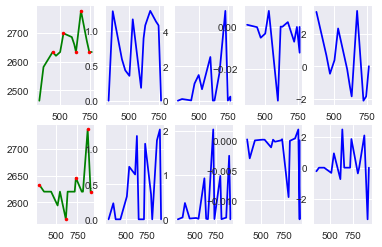

In [17]:
saves = 10000
rows,cols=2,5
data = machine
# data = people
fig,plts = plt.subplots(rows,cols)
for i,s in enumerate(data[300:]):
    if i >= rows:
        break
    index, start, track, des, flag = get_track(s)
    track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
    delta = track[1:] - track[:-1]
    delta[:,2]+=1#固定偏差用来消除0
    
    angular = np.arccos(delta[:,0]/np.sqrt(np.square(delta[:,0])+np.square(delta[:,1])))
    angular = np.nan_to_num(angular)
    angularDeltaTime = np.hstack((angular, delta[:,2]))#x1角度,x2为时间差
    timeAngular = np.hstack((track[1:,2],angular))#x1为时间，x2为角度
    
    angularVelocity = (angular[1:] - angular[:-1])/delta[1:,2]#角速度
    angularVelocityDeltaTime = np.hstack((np.nan_to_num(angularVelocity), delta[1:,2]))#x1角度,x2为时间差
    timeAngularVelocity = np.hstack((track[2:,2],np.nan_to_num(angularVelocity)))#x1为时间，x2为角度
    
    speed = np.sqrt(np.square(delta[:,0])+np.square(delta[:,1]))/delta[:,2]
    timeSpeed = np.hstack((track[1:,2],np.nan_to_num(speed)))#x1为时间，x2为速度
    speedDeltaTime = np.hstack((np.nan_to_num(speed), delta[:,2]))#x1为速度，x2为时间差
    
    acceleration = (speed[1:,0] - speed[:-1,0])/delta[1:,2]#加速度
    accelerationDeltaTime = np.hstack((np.nan_to_num(acceleration), delta[1:,2]))
    timeAcceleration = np.hstack((track[2:,2], np.nan_to_num(acceleration)))
    
    trackGrad = (track[1:,1] - track[:-1,1])/(track[1:,0] - track[:-1,0])
    speedY = delta[:,1]/delta[:,2]
#     trackHessen = (trackGrad[1:] - trackGrad[:-1])/(trackGrad[1:,0] - trackGrad[:-1,0])
    
    
    print(index)
    canvas = plts[i][0]#轨迹
    canvas.plot(track[:,0],track[:,1],'-g')
#     canvas.plot(*start, '.r')
#     stabs = find_stab(track, stride=100, height=25, max_t=100)
    stabs = find_stab_2(track, height=50)
    canvas.plot(stabs[:,0], stabs[:,1], '.r') if stabs is not None else False
#     canvas.plot(*des,'.r')
    canvas = plts[i][1]#角度
    canvas.plot(track[1:,0],angular,'-b')
    canvas = plts[i][2]#移动速度
    canvas.plot(track[1:,0],speed,'-b')
    canvas = plts[i][3]#角速度
    canvas.plot(track[2:,0],angularVelocity,'-b')
#     canvas = plts[i][4]#加速度
#     canvas.plot(track[2:,0],acceleration,'-b')
    canvas = plts[i][4]#轨迹Hessen
    canvas.plot(track[1:,0],trackGrad,'-b')
#     print(track, np.nan_to_num(trackGrad))

/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


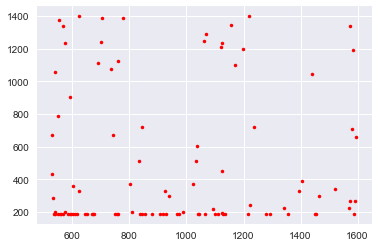

In [18]:
saves = 400
# fig,plts = plt.subplots(2)
# for i,s in enumerate(people):
#     if i >= 1000:
#         break
#     index, start, track, des, flag = get_track(s)
# #     track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
# #     des = np.array(des) + np.array(start)
#     plt.plot(des[0], des[1],'.b')
for i,s in enumerate(machine[-100:]):
    if i >= saves:
        break
    index, start, track, des, flag = get_track(s)
    track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
    delta = track[1:] - track[:-1]
    delta[:,2]+=1#固定偏差用来消除0
    
    angular = np.arccos(delta[:,0]/np.sqrt(np.square(delta[:,0])+np.square(delta[:,1])))
    angular = np.nan_to_num(angular)
#     des = np.array(des) + np.array(start)
#     track = np.vstack([track[0], track, track[-1]])#添加固定偏差来保证数据有效
    plt.plot(des[0], des[1],'.r')

In [ ]:
from random import shuffle
import os
shuffle(people)
saves = 10000

dirs = ['data/people/speed_grad', 'data/people/angle_grad', 'data/people/speed', 'data/people/angle',
       'data/machine/speed_grad', 'data/machine/angle_grad', 'data/machine/speed', 'data/machine/angle']
for dir_ in dirs:
    if not os.path.isdir(dir_) and not os.path.isfile(dir_):
        os.mkdirs(dir_)
        print("mkdir %s"%dir_)
    
for i,s in enumerate(people):
    if i >= saves:
        break
    index, start, track, des, flag = get_track(s)
    delta = track[1:] - track[:-1]
    theta = np.arccos(delta[:,0]/np.sqrt(np.square(delta[:,0])+np.square(delta[:,1])))
    theta_speed = (theta[1:] - theta[:-1])/delta[1:,2]
    speed = np.sqrt(np.square(delta[:,0])+np.square(delta[:,1]))/delta[:,2]
    speed_grad = (speed[1:] - speed[:-1])/delta[1:,2]
#     print(speed)
#     canvas = plt
#     canvas.plot(*start, '.b')
    plt.figure(figsize=(5,5),dpi=20,edgecolor='k')
    plt.plot(track[1:,2],theta,'-b',linewidth=10)
    plt.axis('off')
    plt.savefig('data/people/angle/%s.png'%index)
    plt.close()
    plt.plot(track[1:,2],speed,'-b',linewidth=10)
    plt.axis('off')
    plt.savefig('data/people/speed/%s.png'%index)
    plt.close()
    plt.plot(track[2:,2],theta_speed,'-b',linewidth=10)
    plt.axis('off')
    plt.savefig('data/people/angle_grad/%s.png'%index)
    plt.close()
    plt.plot(track[2:,2],speed_grad,'-b',linewidth=10)
    plt.axis('off')
    plt.savefig('data/people/speed_grad/%s.png'%index)
    plt.close()
    

#     misc.imsave('data/machine/lena_new_sz.png', track)